Introduction:

In [1]:
library(repr)
library(tidyverse)
library(rvest)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────

In [2]:
url <- "https://raw.githubusercontent.com/terrayyyy/ray_ds_project/refs/heads/main/players.csv"

players_data <- read_csv(url)
players_data

# players_data <- read_csv(url, col_names = FALSE)
# colnames(players_data) <- c("experience", "subscribe", "hashedEmail", "played_hours", "name", "gender", "Age")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
players_wrangled <- players_data |>
select(subscribe, played_hours, Age)

players_wrangled

subscribe,played_hours,Age
<lgl>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,NA


In [4]:
players_missing <- sum(is.na(players_wrangled))
players_missing

[1] 2

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


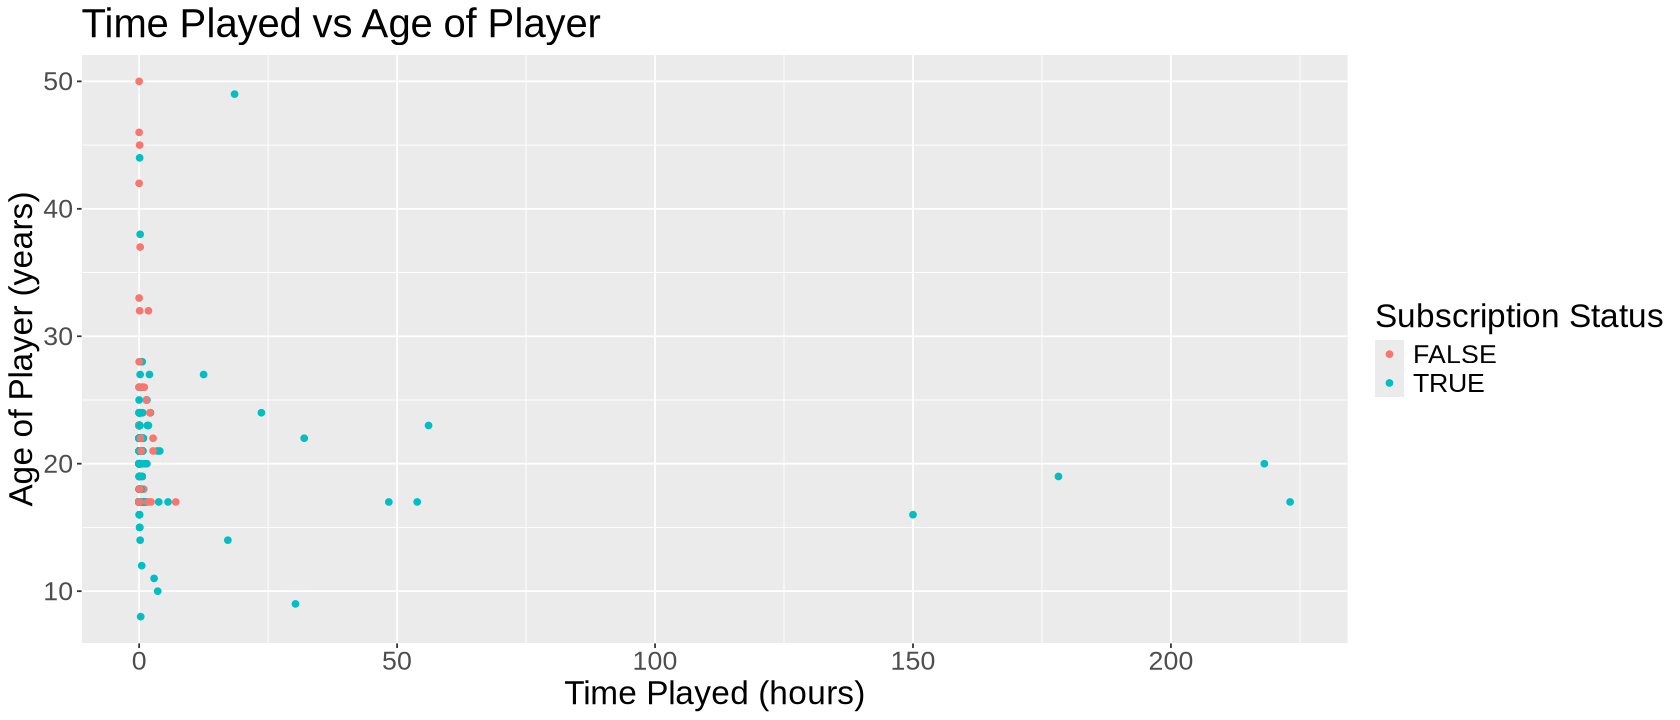

In [11]:
options(repr.plot.width = 14, repr.plot.height = 6)
players_plot <- players_wrangled |>
ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
                       geom_point() +
                       labs(x = "Time Played (hours)", y = "Age of Player (years)", color = "Subscription Status") +
                       ggtitle("Time Played vs Age of Player") +
                       theme(text = element_text(size = 20))

players_plot

Its hard to tell if there is any correlation in this data as the true subscriptions often leak. But this however indicated to us that those who have higher time played in hours are guaranteed to be subscribed.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


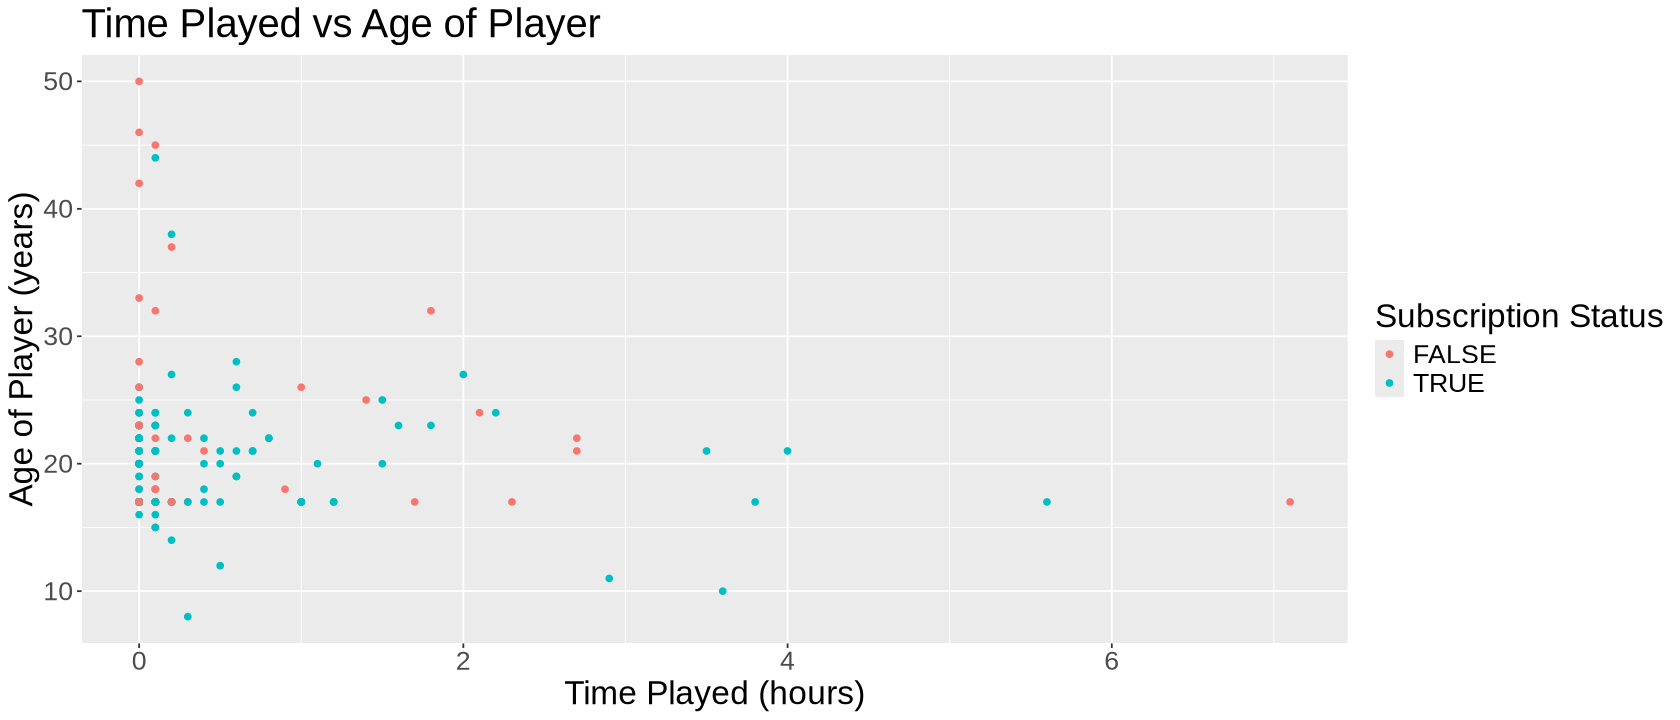

In [23]:
players_plot_shortened <- players_wrangled |>
filter(played_hours < 10) |>
ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
                       geom_point() +
                       labs(x = "Time Played (hours)", y = "Age of Player (years)", color = "Subscription Status") +
                       ggtitle("Time Played vs Age of Player") +
                       theme(text = element_text(size = 20))

players_plot_shortened

Now we have a clearer view of the data, but it is still hard to see if there is any correlation. Hence, a classification model will be used to see how accurate we can classify new points.